In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
from skimage import io, transform, color, img_as_ubyte
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

C:\Users\ahmed\anaconda3\envs\neuralnetwork\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import os
from tensorflow.keras.utils import get_file

# Download DIV2K dataset (train images)
url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
dataset_path = get_file("DIV2K_train_HR.zip", url, extract=True)
image_dir = os.path.join(os.path.dirname(dataset_path), "DIV2K_train_HR")

# Load and preprocess a subset of images
def load_images(image_dir, num_images=10, target_size=(256, 256)):
    images = []
    for i, img_file in enumerate(os.listdir(image_dir)):
        if i >= num_images:
            break
        img_path = os.path.join(image_dir, img_file)
        img = io.imread(img_path)
        img = transform.resize(img, target_size, anti_aliasing=True)
        images.append(img)
    return np.array(images)

# Load 10 high-resolution images
hr_images = load_images(image_dir)
print("Loaded HR images shape:", hr_images.shape)

3530603713/3530603713 [==============================] - 488s 0us/step
Loaded HR images shape: (10, 256, 256, 3)


In [4]:
# Create low-resolution images by downscaling and upscaling
def create_low_res_images(hr_images, scale=4):
    lr_images = []
    for img in hr_images:
        downscaled = transform.rescale(img, 1/scale, channel_axis=-1, anti_aliasing=True)
        upscaled = transform.rescale(downscaled, scale, channel_axis=-1, anti_aliasing=True)
        lr_images.append(upscaled)
    return np.array(lr_images)

lr_images = create_low_res_images(hr_images)
print("Low-Resolution images shape:", lr_images.shape)

Low-Resolution images shape: (10, 256, 256, 3)


In [5]:
def build_srcnn_model():
    model = Sequential([
        Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(256, 256, 3)),
        Conv2D(32, (1, 1), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

srcnn = build_srcnn_model()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Split into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (8, 256, 256, 3), y_train shape: (8, 256, 256, 3)


Epoch 1/10
2/2 [==============================] - 2s 880ms/step - loss: 0.2205 - accuracy: 0.2581 - val_loss: 0.0690 - val_accuracy: 0.5170
Epoch 2/10
2/2 [==============================] - 1s 701ms/step - loss: 0.0465 - accuracy: 0.5589 - val_loss: 0.0472 - val_accuracy: 0.5135
Epoch 3/10
2/2 [==============================] - 1s 664ms/step - loss: 0.0498 - accuracy: 0.4130 - val_loss: 0.0335 - val_accuracy: 0.1185
Epoch 4/10
2/2 [==============================] - 1s 660ms/step - loss: 0.0311 - accuracy: 0.2273 - val_loss: 0.0239 - val_accuracy: 0.1186
Epoch 5/10
2/2 [==============================] - 1s 683ms/step - loss: 0.0231 - accuracy: 0.4942 - val_loss: 0.0285 - val_accuracy: 0.5111
Epoch 6/10
2/2 [==============================] - 1s 657ms/step - loss: 0.0274 - accuracy: 0.5595 - val_loss: 0.0288 - val_accuracy: 0.5127
Epoch 7/10
2/2 [==============================] - 1s 747ms/step - loss: 0.0244 - accuracy: 0.5593 - val_loss: 0.0192 - val_accuracy: 0.5181
Epoch 8/10
2/2 [====

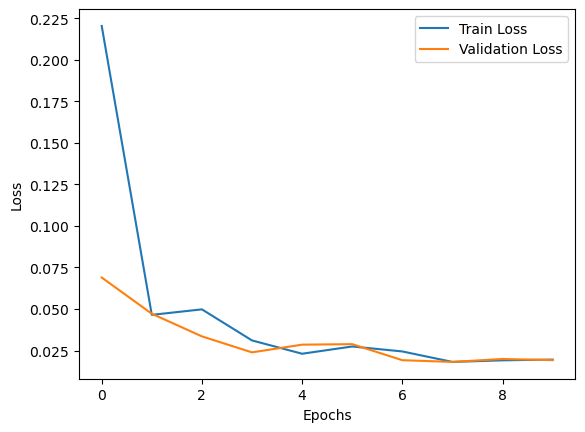

In [7]:
# Train the SRCNN model
history = srcnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=4)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0169215..1.150126].


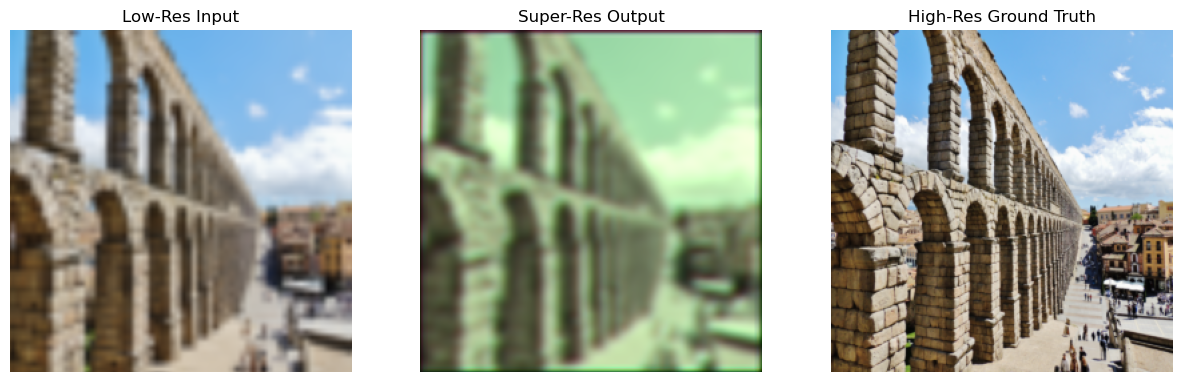

PSNR: 13.81
SSIM: 0.38


In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Test a single example
idx = 0  # Index of the test image to display and evaluate

# Ensure images are in the [0, 255] range and uint8 format for evaluation
y_test_uint8 = (y_test[idx] * 255).astype(np.uint8)
predicted_uint8 = (predicted_images[idx] * 255).astype(np.uint8)

# Compute PSNR and SSIM
psnr_value = psnr(y_test_uint8, predicted_uint8, data_range=255)
ssim_value = ssim(y_test_uint8, predicted_uint8, data_range=255, channel_axis=-1, win_size=5)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Low-Res Input")
plt.imshow(x_test[idx])
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Super-Res Output")
plt.imshow(predicted_images[idx])
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("High-Res Ground Truth")
plt.imshow(y_test[idx])
plt.axis("off")

plt.show()

# Print metrics
print(f"PSNR: {psnr_value:.2f}")
print(f"SSIM: {ssim_value:.2f}")